# Visualize 2D synthetic density estimation result

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from models.modules import FCNet, IsotropicGaussian, FCResNet
from models.ae import AE, VAE
from models.nae import NAE
from models.bnaf import BNAF
from loader.synthetic import sample2d

In [2]:
device = 'cpu:0'

In [3]:
dset = '8gaussians'
if dset == '8gaussians':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
elif dset == '2spirals':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
elif dset == 'checkerboard':
    xmin, xmax, ymin, ymax = [-4, 4, -4, 4]


In [4]:
XX, YY = torch.meshgrid(torch.linspace(xmin, xmax, 100), torch.linspace(ymin,ymax, 100))
grid = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], dim=1)
grid_gpu = grid
grid_gpu = grid.to(device)

# AE

In [41]:
zdim = 2
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='spherical')
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear')
ae = AE(encoder, IsotropicGaussian(decoder, sigma=0.5, sigma_trainable=True, error_normalize=False))
ae.load_state_dict(torch.load('ae_2_8gaussians.pth'))
ae.to(device);

In [42]:
z_grid = ae.encoder(grid_gpu)
E_ae = - ae.decoder.log_likelihood(grid_gpu, z_grid).detach().cpu().reshape(100, 100)
Omega = ((8 / 100 * 8 / 100) * np.exp(-E_ae)).sum()
p_ae = np.exp(-E_ae.T)/Omega

In [56]:
zdim = 3
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='tanh')
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear')
ae = AE(encoder, IsotropicGaussian(decoder, sigma=0.5, sigma_trainable=True, error_normalize=False))
ae.load_state_dict(torch.load('ae_3_8gaussians.pth'))
ae.to(device);

In [57]:
z_grid = ae.encoder(grid_gpu)
E_ae = - ae.decoder.log_likelihood(grid_gpu, z_grid).detach().cpu().reshape(100, 100)
Omega = ((8 / 100 * 8 / 100) * np.exp(-E_ae)).sum()
p_ae_3 = np.exp(-E_ae.T)/Omega

# VAE

In [29]:
zdim = 1
encoder = FCResNet(2, zdim * 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear')
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear')
vae = VAE(encoder, decoder, sigma_trainable=True, use_mean=False)
vae.load_state_dict(torch.load('vae_1_8gaussians.pth'))
vae.to(device);

In [30]:
vae.n_sample = 100
p_vae = np.exp(-vae.reconstruction_probability(grid_gpu).detach().cpu()).reshape((100,100))

In [31]:
gg = vae.marginal_likelihood(grid_gpu, n_sample=500).detach().cpu()
p_vae = torch.exp(gg.reshape(100, 100))

In [32]:
zdim = 3
encoder = FCResNet(2, zdim * 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear')
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear')
vae = VAE(encoder, decoder, sigma_trainable=True, use_mean=False)
vae.load_state_dict(torch.load('vae_3_8gaussians.pth'))
vae.to(device);

In [33]:
vae.n_sample = 100
# p_vae_3 = np.exp(-vae.reconstruction_probability(grid_gpu).detach().cpu()).reshape((100,100))
gg = vae.marginal_likelihood(grid_gpu, n_sample=500).detach().cpu() #- np.log(1000)
p_vae_3 = torch.exp(gg.reshape(100, 100))

In [40]:
p_vae.flatten().numpy()

array([1.7686924e-14, 5.9889587e-14, 1.9335102e-13, ..., 4.2174089e-14,
       7.4579260e-15, 3.1438937e-15], dtype=float32)

(array([  23.,   65.,  142.,  243.,  405.,  672., 1065., 1762., 3418.,
        2205.]),
 array([-33.914597  , -30.546408  , -27.17822   , -23.810032  ,
        -20.441845  , -17.073656  , -13.705469  , -10.337281  ,
         -6.969093  ,  -3.600905  ,  -0.23271702], dtype=float32),
 <BarContainer object of 10 artists>)

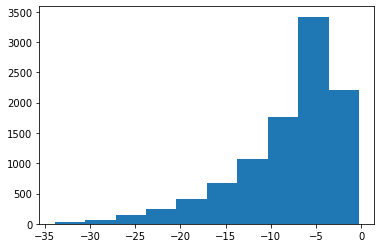

In [38]:
plt.hist(np.log(p_vae.flatten().numpy()))

# NAE

In [83]:
zdim = 2
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
nae = NAE(encoder, decoder, sampling='on_manifold',
           x_step=30, x_stepsize=None, x_noise_std=0.1, x_bound=(-5, 5), x_clip_langevin_grad=None,
           z_step=10, z_stepsize=None, z_noise_std=0.1, z_bound=None, z_clip_langevin_grad=None,
           gamma=1, delta=0., spherical=True,
           sigma=0.5, sigma_trainable=True,
           temperature=0.5, temperature_trainable=True,
           l2_norm_reg=None, l2_norm_reg_en=None, z_norm_reg=None,
           initial_dist='gaussian', replay=True, replay_ratio=0.95, buffer_size=10000,
           deterministic=True, mh=True, mh_z=False, reject_boundary=True, reject_boundary_z=True)
nae.load_state_dict(torch.load('nae_2_8gaussians.pth'))
# nae.to(device);

<All keys matched successfully>

In [84]:
E = nae.energy_T(grid_gpu).detach().cpu().reshape(100, 100)
# E = nae.energy(grid_gpu).detach().cpu().reshape(100, 100)
Omega = ((8 / 100 * 8 / 100) * np.exp(-E)).sum()
p_nae = np.exp(-E.T)/Omega

In [85]:
zdim = 3
encoder = FCResNet(2, zdim, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
decoder = FCResNet(zdim, 2, res_dim=256, n_res_hidden=1024, n_resblock=5, out_activation='linear', use_spectral_norm=False)
nae = NAE(encoder, decoder, sampling='on_manifold',
           x_step=30, x_stepsize=None, x_noise_std=0.1, x_bound=(-5, 5), x_clip_langevin_grad=None,
           z_step=10, z_stepsize=None, z_noise_std=0.1, z_bound=None, z_clip_langevin_grad=None,
           gamma=1, delta=0., spherical=False,
           sigma=1, sigma_trainable=False,
           temperature=0.1, temperature_trainable=True,
           l2_norm_reg=None, l2_norm_reg_en=None, z_norm_reg=0.01,
           initial_dist='gaussian', replay=True, replay_ratio=0.95, buffer_size=10000,
           deterministic=True, mh=True, mh_z=False, reject_boundary=True, reject_boundary_z=True)
nae.load_state_dict(torch.load('nae_3_8gaussians.pth'))
# nae.to(device);

<All keys matched successfully>

In [86]:
E = nae.energy_T(grid_gpu).detach().cpu().reshape(100, 100)
# E = nae.energy(grid_gpu).detach().cpu().reshape(100, 100)
Omega = ((8 / 100 * 8 / 100) * np.exp(-E)).sum()
p_nae_3 = np.exp(-E.T)/Omega

# BNAF

* 저장했던 파일을 불러옴

In [18]:
# bnaf = BNAF(1,3, 2, 50)
# bnaf.load_state_dict(torch.load('bnaf_8gaussians.pth'))
# bnaf.to(device)

In [19]:
# model = bnaf
# gg = model.log_likelihood(grid.to(device)).detach().cpu()
# prd = gg.reshape(100, 100)
# bnaf_pred = prd

In [20]:
# plt.imshow(np.exp(bnaf_pred), origin='upper', extent=(-4, 4, -4, 4))
# plt.colorbar()
# # plt.xticks(np.linspace(-4,4,100));

# Gaussian

In [21]:
from torch.distributions import Normal

In [22]:
g1 = Normal(torch.tensor([4/np.sqrt(2),0]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g2 = Normal(torch.tensor([-4/np.sqrt(2),0]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g3 = Normal(torch.tensor([0,4/np.sqrt(2)]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g4 = Normal(torch.tensor([0,-4/np.sqrt(2)]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g5 = Normal(torch.tensor([2,2]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g6 = Normal(torch.tensor([-2,2]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g7 = Normal(torch.tensor([2,-2]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))
g8 = Normal(torch.tensor([-2,-2]), torch.tensor([0.5/np.sqrt(2), 0.5/np.sqrt(2)]))

In [23]:
p1 = torch.exp(g1.log_prob(grid).sum(dim=1))
p2 = torch.exp(g2.log_prob(grid).sum(dim=1))
p3 = torch.exp(g3.log_prob(grid).sum(dim=1))
p4 = torch.exp(g4.log_prob(grid).sum(dim=1))
p5 = torch.exp(g5.log_prob(grid).sum(dim=1))
p6 = torch.exp(g6.log_prob(grid).sum(dim=1))
p7 = torch.exp(g7.log_prob(grid).sum(dim=1))
p8 = torch.exp(g8.log_prob(grid).sum(dim=1))

In [24]:
p_8gaussian = (p1 + p2 + p3 + p4 + p5+ p6+ p7 + p8) / 8

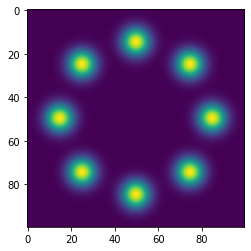

In [25]:
plt.imshow(p_8gaussian.reshape(100,100))

# Figure drawing

In [26]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [46]:
p_vae.max()

tensor(0.7924)

In [47]:
p_vae_3.max()

tensor(0.4405)

In [48]:
p_nae_3.max()

tensor(0.3078)

In [49]:
p_8gaussian.max()

tensor(0.1586, dtype=torch.float64)

In [50]:
p_ae.max()

tensor(0.0286)

In [43]:
cat_p = np.concatenate([p_ae.flatten(), p_vae.flatten(), p_nae.flatten(), p_ae_3.flatten(), p_nae_3.flatten()]) # p_vae_3.flatten(),
p_max = cat_p.max()

In [74]:
p_max = p_8gaussian.max()

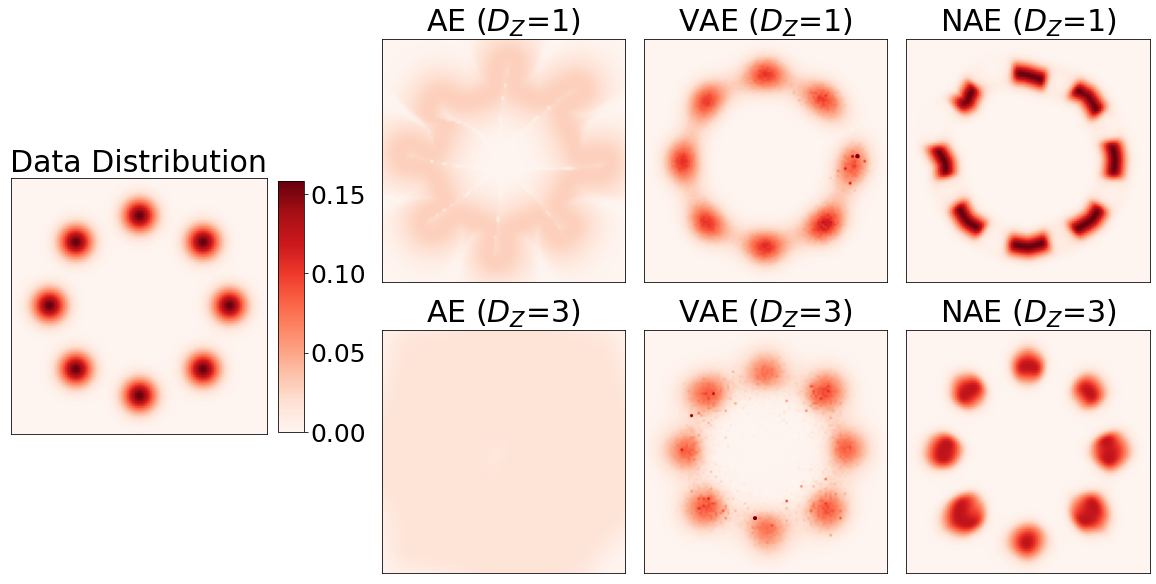

In [88]:
plt.rcParams.update({'font.size': 25})
fig = plt.figure(constrained_layout=True, figsize=(16,8))
spec = fig.add_gridspec(ncols=4, nrows=2,)
ax = fig.add_subplot(spec[:,0])
ax.imshow(p_8gaussian.reshape(100,100), origin='lower', extent=(-4, 4, -4, 4), cmap='Reds',)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title('Data Distribution')
plt.colorbar(im, ax=ax, shrink=0.47)

ax = fig.add_subplot(spec[0,1])
ax.imshow(p_ae, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_title('AE ($D_Z$=1)')
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(spec[0,2])
ax.imshow(p_vae, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_title('VAE ($D_Z$=1)')
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(spec[0,3])
im = ax.imshow(p_nae, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_title('NAE ($D_Z$=1)')
ax.set_xticks([]); ax.set_yticks([])


ax = fig.add_subplot(spec[1,1])
ax.imshow(p_ae_3, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_title('AE ($D_Z$=3)')
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(spec[1,2])
ax.imshow(p_vae_3, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_title('VAE ($D_Z$=3)')
ax.set_xticks([]); ax.set_yticks([])

ax = fig.add_subplot(spec[1,3])
ax.imshow(p_nae_3, origin='lower', extent=(-4, 4, -4, 4), cmap='Reds', vmin=0, vmax=p_max)
ax.set_title('NAE ($D_Z$=3)')
ax.set_xticks([]); ax.set_yticks([])
plt.savefig('fig_2d_density_estimation.pdf', bbox_inches='tight')